<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 2 - Aplicaciones Recientes de Redes Neuronales </H3>
<H3 align='center'> Pregunta 4 - Distintos tipos de autoencoders (AEs) en MNIST</H3>
<hr style="height:2px;border:none"/>

**Librerias**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from google.colab import drive

In [3]:
import keras.backend as K
from keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D, Reshape
from keras.layers import Lambda, UpSampling2D, Conv2DTranspose, Activation
from keras.models import load_model, Model
from keras.metrics import binary_crossentropy, mean_squared_error

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

Using TensorFlow backend.


In [4]:
fdir = 'gdrive/My Drive/Colab Notebooks/'
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**Dataset**

In [5]:
from keras.datasets import mnist

# Load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Canales en formato channels_last
x_train = x_train[:,:,:,None]
x_test = x_test[:,:,:,None]
# Dimensiones
img_rows, img_cols, channel = x_train.shape[1:]
original_img_size = (img_rows, img_cols, channel) # input image dimensions
# Normalizado
x_train = x_train.astype('float32') / 255. 
x_test = x_test.astype('float32') / 255. 

11493376/11490434 [==============================] - 2s 0us/step


In [0]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

**Descripción**

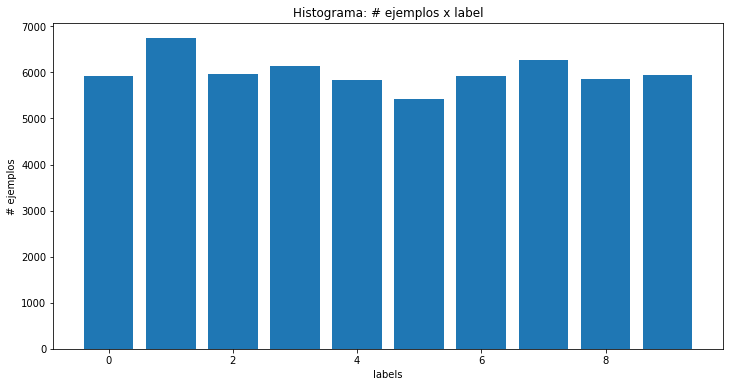

In [0]:
# Distro longitud sentencias
labels_hist = pd.Series(y_train).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(labels_hist.index, labels_hist.values)
ax.set_xlabel('labels')
ax.set_ylabel('# ejemplos')
ax.set_title("Histograma: # ejemplos x label")
plt.show()

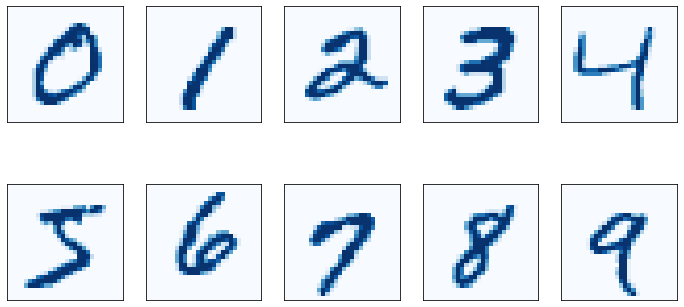

In [0]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i in range(2):
  for j in range(5):
    k = np.argmax(y_train == 5*i +j)
    axes[i][j].imshow(x_train[k,:,:,0], cmap='Blues')
    axes[i][j].get_xaxis().set_visible(False)
    axes[i][j].get_yaxis().set_visible(False)
plt.show()

# 4.1 Autoencoder clásico

## a)

ReLu factible de usar en el encoder ya que es una sola capa. Dominio de ReLu es $[0, \inf)$, por lo que, en redes profundas, los valores (activación) pueden dispararse y crecer mucho.

Es necesario que el decoder entrege valores entre 0 y 1, pues está generando una imágen. Por esto, la última capa del decoder está forzada a tener activación sigmoidal. 



En el autoencoder, se reducen las dimensiones del input en la parte del encoder, generando un vector de menor dimensionalidad. El decoder, luego, usa el vector para aumentar las dimensiones y generar una salida de la misma dimensionalidad que el input. Este proceso, especialmente el del decoder, se asemeja más a una regresión que a una clasificación. Por esto, las funciones de perdida para regresión deberían funcionar mejor en un autoencoder que funciones de perdida para clasificación.

Los valores de las imágenes y de las salidas están en el rango $[0, 1]$, luego, _mse_ podría tener el problema de que el termino $(q_{true} - q_{pred})^2$ se reduzca mucho. Pero, al probar con _mae_, que no tendría este problema, se obtiene un peor desempeño. Adicionalmente, se prueba con _msle_ y se obtiene mejor resultado que con simple _mse_.

Dimensiones (parámetros entrenables)

- Decoder: tiene `784 x compres_dim` pesos, más `compres_dim` biases.
- Encoder: `compres_dim x 784` pesos y `784` biases.





In [0]:
import time
from keras.callbacks import Callback

class TimeHistory(Callback):
  def on_train_begin(self, logs=None):
    self.times = []

  def on_epoch_begin(self, epoch, logs=None):
    self.epoch_time_start = time.time()

  def on_epoch_end(self, epoch, logs=None):
    self.times.append(time.time() - self.epoch_time_start)

  def on_predict_begin(self, logs=None):
    self.predict_time = time.time()

  def on_predict_end(self, logs=None):
    self.predict_time = time.time() - self.predict_time

In [0]:
l_dims = [2, 8, 16, 32]

for compres_dim in l_dims:
  input_img = Input(shape=original_img_size)
  input_fl = Flatten()(input_img) # 1D vector
  # Encoder
  encoded = Dense(compres_dim, activation='relu')(input_fl)
  # Decoder
  decoded = Dense(np.prod(original_img_size), activation='sigmoid')(encoded)
  decoded = Reshape(original_img_size)(decoded)
  #
  autoencoder = Model(inputs=input_img, outputs=decoded)
  encoder = Model(inputs=input_img, outputs=encoded)
  # Training
  autoencoder.compile(optimizer='rmsprop', loss='msle')
  time_callback = TimeHistory()
  hist = autoencoder.fit(x_train, x_train, epochs=40, batch_size=32, validation_data=(x_test, x_test), callbacks=[time_callback], verbose=False)
  # Save & stats
  autoencoder.save(fdir+'basic_autoencoder_{}.h5'.format(compres_dim))
  encoder.save(fdir+'basic_encoder_{}.h5'.format(compres_dim))
  print("  Compression d': {}".format(compres_dim))
  print("       Test loss: {}".format(hist.history['loss'][-1]))
  print("        Val loss: {}".format(hist.history['val_loss'][-1]))
  print("  Train time [s]: {}".format(sum(time_callback.times)))
  print("Time x epoch [s]: {}".format(np.average(time_callback.times)))
  print()

  Compression d': 2
       Test loss: 0.027451782768964768
        Val loss: 0.02729353541135788
  Train time [s]: 185.96216201782227
Time x epoch [s]: 4.649054050445557

  Compression d': 8
       Test loss: 0.016456425352394582
        Val loss: 0.01621365951895714
  Train time [s]: 186.999587059021
Time x epoch [s]: 4.6749896764755245

  Compression d': 16
       Test loss: 0.010123465730498235
        Val loss: 0.009888607420027257
  Train time [s]: 188.7325897216797
Time x epoch [s]: 4.718314743041992

  Compression d': 32
       Test loss: 0.004782615505158901
        Val loss: 0.004652861967682839
  Train time [s]: 193.5311357975006
Time x epoch [s]: 4.838278394937515



## b)

Ĺas imágenes de los números $4$, $7$ y $9$, puede que sean las más fáciles de confundir entre sí por el modelo. El grupo de $0$, $2$ y $6$ es posible que también sea fácil de confundir entre sí.

Se observan considerables mejoras a medida que se aumenta el número de dimensiones de la representación reducida del input. Esto se condice con la mejora en la _loss_, para testing y validación, a medida que se aumenta la dimensión.

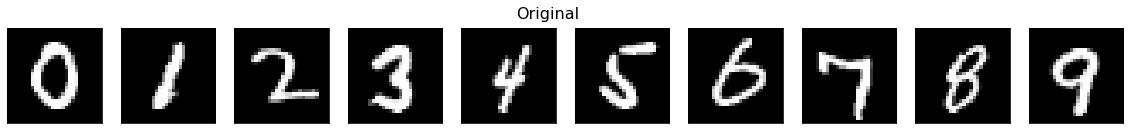

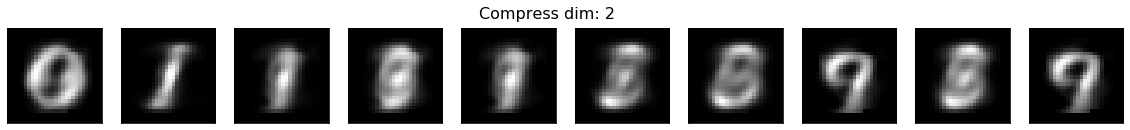

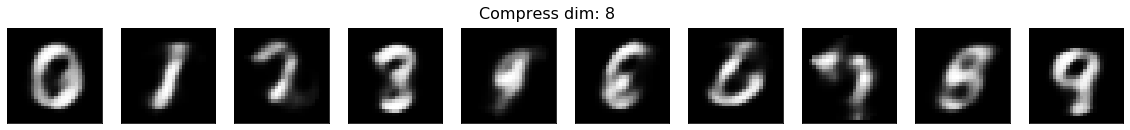

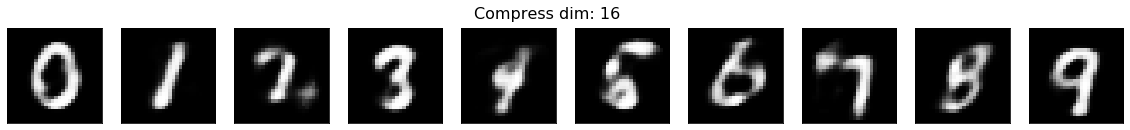

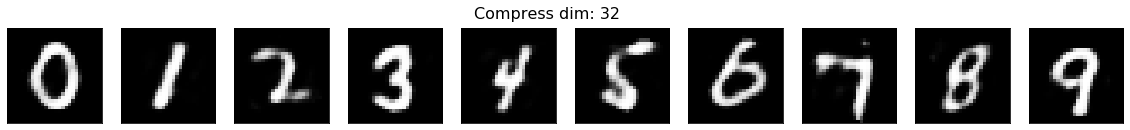

In [0]:
l_ix = [np.random.choice(np.where(y_test == k)[0]) for k in range(10)]
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
fig.suptitle('Original', fontsize=16)
for i, k in enumerate(l_ix):
  axes[i].imshow(x_test[k].reshape(28, 28),cmap='gray')
  axes[i].get_xaxis().set_visible(False)
  axes[i].get_yaxis().set_visible(False)

l_dims = [2, 8, 16, 32]
for compres_dim in l_dims:
  autoencoder = load_model(fdir+'basic_autoencoder_{}.h5'.format(compres_dim))
  #encoder = load_model(fdir+'basic_encoder_{}.h5'.format(compres_dim))
  decoded_test = autoencoder.predict(x_test)
  fig, axes = plt.subplots(1, 10, figsize=(20, 2))
  fig.suptitle('Compress dim: {}'.format(compres_dim), fontsize=16)
  for i, k in enumerate(l_ix):
    axes[i].imshow(decoded_test[k].reshape(28, 28), cmap='gray')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)

## c)

In [0]:
# TODO tiempos medios de predicción??

n_attr = np.prod(original_img_size)
l_dims = [2, 8, 16, 32]
for compres_dim in l_dims:
  print("Reduction dim [d']: {}".format(compres_dim))
  # Reduccion PCA
  pca = PCA(n_components=compres_dim)
  pca.fit(x_train.reshape(x_train.shape[0],n_attr))
  pca_train = pca.transform(x_train.reshape(x_train.shape[0],n_attr))
  pca_test = pca.transform(x_test.reshape(x_test.shape[0],n_attr))
  # Reduccion encoder
  encoder = load_model(fdir+'basic_encoder_{}.h5'.format(compres_dim))
  encoded_train = encoder.predict(x_train)
  encoded_test = encoder.predict(x_test)
  # Clasificacion
  clf = KNeighborsClassifier(10)
  tt_pca_fit = time.time()
  clf.fit(pca_train, y_train)
  tt_pca_fit = time.time() - tt_pca_fit
  tt_pca_sco = time.time()
  pca_score = clf.score(pca_test,y_test)
  tt_pca_sco = time.time() - tt_pca_sco
  print("Classif Accuracy w/PCA: {}".format(pca_score))
  print("          Fit time [s]: {:.3f}".format(tt_pca_fit)) # TODO agregar training time??
  print("        Score time [s]: {:.3f}".format(tt_pca_sco))
  clf = KNeighborsClassifier(10)
  tt_enc_fit = time.time()
  clf.fit(encoded_train, y_train)
  tt_enc_fit = time.time() - tt_enc_fit
  tt_enc_sco = time.time()
  enc_score = clf.score(encoded_test,y_test)
  tt_enc_sco = time.time() - tt_enc_sco
  print("Classif Acc. w/encoder: {}".format(enc_score))
  print("          Fit time [s]: {:.3f}".format(tt_enc_fit))
  print("        Score time [s]: {:.3f}".format(tt_enc_sco))
  print()

Reduction dim [d']: 2
Classif Accuracy w/PCA: 0.4424
          Fit time [s]: 0.033
        Score time [s]: 0.243
Classif Acc. w/encoder: 0.4393
          Fit time [s]: 0.028
        Score time [s]: 0.244

Reduction dim [d']: 8
Classif Accuracy w/PCA: 0.903
          Fit time [s]: 0.039
        Score time [s]: 1.075
Classif Acc. w/encoder: 0.8992
          Fit time [s]: 0.044
        Score time [s]: 1.013

Reduction dim [d']: 16
Classif Accuracy w/PCA: 0.9615
          Fit time [s]: 0.067
        Score time [s]: 5.395
Classif Acc. w/encoder: 0.9567
          Fit time [s]: 0.065
        Score time [s]: 6.178

Reduction dim [d']: 32
Classif Accuracy w/PCA: 0.974
          Fit time [s]: 0.121
        Score time [s]: 16.766
Classif Acc. w/encoder: 0.9696
          Fit time [s]: 0.126
        Score time [s]: 26.185



## d)

In [0]:
l_dims = [2, 8, 16, 32]
for compres_dim in l_dims:
  input_img = Input(shape=original_img_size)
  # Encoder
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  before_F_shape =  (x.shape[1].value, x.shape[2].value, x.shape[3].value)
  x = Flatten()(x)
  encoded = Dense(compres_dim, activation='relu')(x)
  # Decoder
  x = Dense(np.prod(before_F_shape),activation='relu')(encoded)
  x = Reshape(before_F_shape)(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
  # Models
  autoencoder = Model(input_img, decoded)
  encoder = Model(input_img, encoded)
  #autoencoder.summary()
  # Training
  autoencoder.compile(optimizer='rmsprop', loss='msle')
  time_callback = TimeHistory()
  hist = autoencoder.fit(x_train, x_train,epochs=40, batch_size=32, validation_data=(x_test,x_test), callbacks=[time_callback], verbose=False)
  # Save & stats
  autoencoder.save(fdir+'deep_autoencoder_{}.h5'.format(compres_dim))
  encoder.save(fdir+'deep_encoder_{}.h5'.format(compres_dim))
  print("  Compression d': {}".format(compres_dim))
  print("       Test loss: {}".format(hist.history['loss'][-1]))
  print("        Val loss: {}".format(hist.history['val_loss'][-1]))
  print("  Train time [s]: {}".format(sum(time_callback.times)))
  print("Time x epoch [s]: {}".format(np.average(time_callback.times)))
  print()

  Compression d': 2
       Test loss: 0.020299501570065815
        Val loss: 0.02034508204460144
  Train time [s]: 433.9601848125458
Time x epoch [s]: 10.849004620313645

  Compression d': 8
       Test loss: 0.0077361083013316
        Val loss: 0.008156497015058994
  Train time [s]: 431.8214225769043
Time x epoch [s]: 10.795535564422607

  Compression d': 16
       Test loss: 0.003728743668521444
        Val loss: 0.003971640203148127
  Train time [s]: 434.1502559185028
Time x epoch [s]: 10.85375639796257

  Compression d': 32
       Test loss: 0.002173778142593801
        Val loss: 0.002121732173115015
  Train time [s]: 436.8650813102722
Time x epoch [s]: 10.921627032756806



In [0]:
n_attr = np.prod(original_img_size)
l_dims = [2, 8, 16, 32]
for compres_dim in l_dims:
  print("Reduction dim [d']: {}".format(compres_dim))
  # Reduccion PCA
  pca = PCA(n_components=compres_dim)
  pca.fit(x_train.reshape(x_train.shape[0],n_attr))
  pca_train = pca.transform(x_train.reshape(x_train.shape[0],n_attr))
  pca_test = pca.transform(x_test.reshape(x_test.shape[0],n_attr))
  # Reduccion encoder
  encoder = load_model(fdir+'deep_encoder_{}.h5'.format(compres_dim))
  encoded_train = encoder.predict(x_train)
  encoded_test = encoder.predict(x_test)
  # Clasificacion
  clf = KNeighborsClassifier(10)
  clf.fit(pca_train, y_train)
  print("Classif Accuracy w/PCA: {}".format(clf.score(pca_test,y_test)))
  clf = KNeighborsClassifier(10)
  clf.fit(encoded_train, y_train)
  print("Classif Acc. w/encoder: {}".format(clf.score(encoded_test,y_test)))
  print()

Reduction dim [d']: 2
Classif Accuracy w/PCA: 0.4427
Classif Acc. w/encoder: 0.6535

Reduction dim [d']: 8
Classif Accuracy w/PCA: 0.9031
Classif Acc. w/encoder: 0.9479

Reduction dim [d']: 16
Classif Accuracy w/PCA: 0.9612
Classif Acc. w/encoder: 0.9724

Reduction dim [d']: 32
Classif Accuracy w/PCA: 0.9742
Classif Acc. w/encoder: 0.9775



## e)

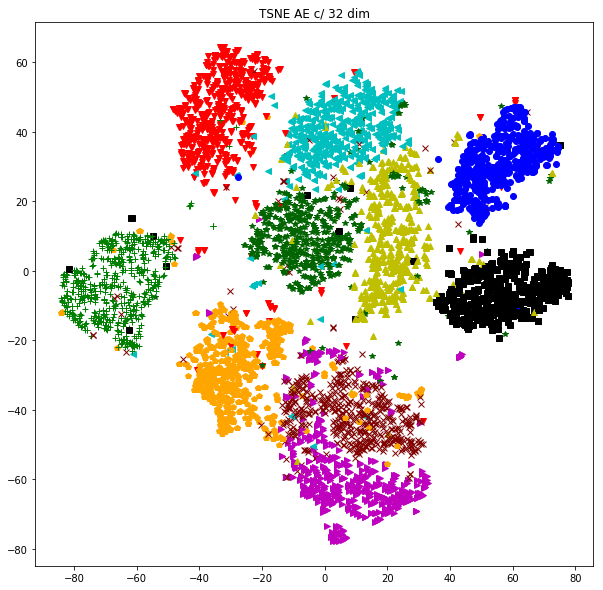

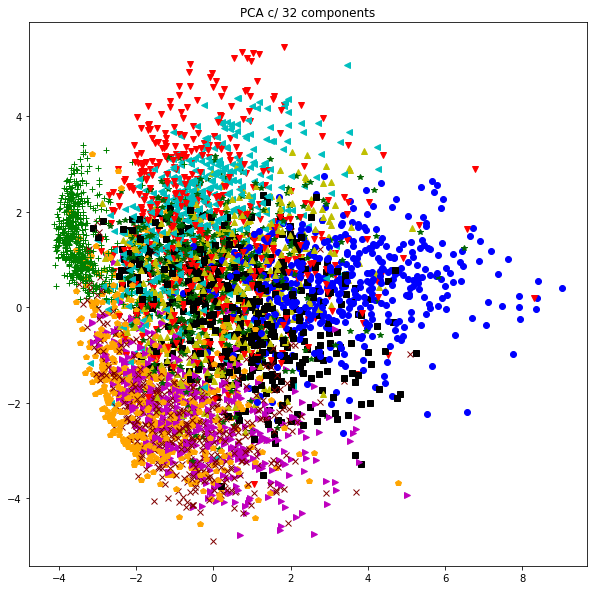

In [0]:
nplot=5000 #warning: mind your memory!
compres_dim = 32
encoder = load_model(fdir+'deep_encoder_{}.h5'.format(compres_dim))
encoded_test = encoder.predict(x_test[:nplot])

model = TSNE(n_components=2, random_state=0)
encoded_test = model.fit_transform(encoded_test)

plt.figure(figsize=(10, 10))
plt.title("TSNE AE c/ {} dim".format(compres_dim))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
  label = y_test[idx]
  line = plt.plot(encoded_test[idx][0], encoded_test[idx][1],
                  color=colors[label], marker=markers[label], markersize=6)

n_attr = np.prod(original_img_size)
pca = PCA(n_components=compres_dim)
pca.fit(x_test.reshape(x_test.shape[0],n_attr))
pca_test = pca.transform(x_test.reshape(x_test.shape[0],n_attr))
encoded_test = pca_test[:nplot]
plt.figure(figsize=(10, 10))
plt.title("PCA c/ {} components".format(compres_dim))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
  label = y_test[idx]
  line = plt.plot(encoded_test[idx][0], encoded_test[idx][1],
                  color=colors[label], marker=markers[label], markersize=6)

# 4.2 _Variational Autoencoder_ tradicional

## a) Encoder

El encoder consta de tres capas convolucionales. La primera capa se compone de 32 filtros y kernel de 3x3 con _padding_ que conserva las primeras dos dimensiones del input. La entrada tiene un tamaño de `(28 x 28 x 1)` y la salida,`(28 x 28 x 32)` . Dado el tamaño del kernel, los canales de entrada y de salida se tienen $9 * 32 + 32 = 320$ parámetros en esta capa. La capa siguiente también tiene 32 filtros, kernel de 3 x 3 y `padding = "same"`, por lo que se tienen, $9 *32*32 + 32 = 9.248$ parámetros. La tercera capa convolucional tiene 64 filtros, kernel de 3 x 3 y `stride = 2`, lo que divide por la mitad las primeras dos dimensiones y la salida tiene un tamaño de `(14 x 14 x 64)`. Esta capa tiene $9*32*64 +64=18.496$ parámetros entrenables.

Luego, el cubo de salida se convierte a un vector unidimensional y se usa de input para la capa densa intermedia de 128 neuronas. Esta capa tienee $ 18.496*128 + 128 =1.605.760$ parámetros. 

Finalmente, se tienen las dos capas densas que representan las variables latentes de la distribución que define los datos. Estas últimas dos capas tienen 2 neuronas cada una y tienen de input la salida de la capa densa anterior de 128 neuronas. 

In [0]:
filters = 32 # number of convolutional filters to use
num_conv = 3 # convolution kernel size
intermediate_dim = 128
latent_dim = 2
# Encoder
x = Input(shape=original_img_size, name="input_vae")
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu', name="conv_1")(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu', name="conv_2")(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2, name="conv_3")(conv_2)
flat = Flatten(name="flat_enco")(conv_3)
hidden = Dense(intermediate_dim, activation='relu', name="inter_enco")(flat)
z_mean = Dense(latent_dim,activation='linear', name="z_mean")(hidden)
z_log_var = Dense(latent_dim,activation='linear', name="z_log_var")(hidden)
encoder = Model(x, [z_mean, z_log_var])# build a model to project inputs on the latent space

encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_vae (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 28, 28, 32)   320         input_vae[0][0]                  
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 28, 28, 32)   9248        conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 14, 14, 64)   18496       conv_2[0][0]                     
__________________________________________________________________________________________________
flat_enco 

## b) Decoder

Ahora, se hace el proceso inverso al del _encoder_. 


Primero, el vector de entrada (unidimensional de tamaño 2) se lleva a una representación intermedia pasandolo por una capa densa de 128 neuronas, que tiene $2*128 + 128 = 384$ parámetros. Luego, se hace un _up-sampling_ con una capa densa de $14*14*64 = 12.544$ neuronas. El vector se transforma en una matriz tri-dimensional de tamaño `(14 x 14 x 64)` que se pasará por tres capas convolucionales transpuestas para generar finalmente la salida de la red con tamaño `(28 x 28 x 1)` como las imagenes de entrada de 28 x 28 pixeles con un canal.

La convolución transpuesta es una forma de _up-sampling_ que usa una operación convolucional pero que aumenta el tamaño del input en vez de reducirlo como en una convolución tradicional. Para lograr esto se intercalan ceros entre los datos de entrada según lo indicado en el parámetro `stride`.

También, se puede entender el `stride` como la forma en que se van poniendo los valores obtenidos con el kernel  en la matriz de ouput. Así, si, en una capa convolucional, el _stride_ determina el número de celdas que se mueve el kernel para realizar cada operación; en una capa convolucional transpuesta, el _stride_ determina el número de celdas que se mueve el índice al insertar valores en la matriz de _output_.

In [0]:
shape_before_flattening = K.int_shape(conv_3)[1:] # we instantiate these layers separately to reuse them later

decoder_hid = Dense(intermediate_dim, activation='relu', name="inter_deco")
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu', name="upsampling")
decoder_reshape = Reshape(shape_before_flattening, name="reshape_deco")
decoder_deconv_1 = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=2, activation='relu', name="convT_1")
decoder_deconv_2 = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', activation='relu', name="convT_2")
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv, padding='same', activation='sigmoid', name="convT_3")

## c)

In [0]:
def make_sampling(latent_dim):
  def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon
  return sampling

In [0]:
z = Lambda(make_sampling(latent_dim), output_shape=(latent_dim,), name="sampling")([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

vae_norm = Model(x, x_decoded_mean_squash) # instantiate VAE model
vae_encoder = Model(x, z)

vae_norm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_vae (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 28, 28, 32)   320         input_vae[0][0]                  
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 28, 28, 32)   9248        conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 14, 14, 64)   18496       conv_2[0][0]                     
__________________________________________________________________________________________________
flat_enco 

## d)

In [0]:
#choised_loss = binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss = mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #closed form
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_norm.add_loss(vae_loss)

vae_norm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_vae (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 28, 28, 32)   320         input_vae[0][0]                  
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 28, 28, 32)   9248        conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 14, 14, 64)   18496       conv_2[0][0]                     
__________________________________________________________________________________________________
flat_enco 

## e) Entrenamiento

In [0]:
batch_size = 128
epochs =  30

vae_norm.compile(optimizer='rmsprop')
vae_norm.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 21s 349us/step - loss: 39.7737 - val_loss: 37.6463
Epoch 2/30
60000/60000 [==============================] - 20s 325us/step - loss: 37.3323 - val_loss: 37.0781
Epoch 3/30
60000/60000 [==============================] - 20s 325us/step - loss: 36.0324 - val_loss: 35.9201
Epoch 4/30
60000/60000 [==============================] - 20s 327us/step - loss: 35.1463 - val_loss: 35.6048
Epoch 5/30
60000/60000 [==============================] - 19s 324us/step - loss: 34.5616 - val_loss: 33.7775
Epoch 6/30
60000/60000 [==============================] - 19s 324us/step - loss: 34.0765 - val_loss: 34.7381
Epoch 7/30
60000/60000 [==============================] - 19s 325us/step - loss: 33.7393 - val_loss: 34.3951
Epoch 8/30
60000/60000 [==============================] - 20s 332us/step - loss: 33.4556 - val_loss: 33.3412
Epoch 9/30
60000/60000 [==============================] - 20s 329us/step - los

## f)

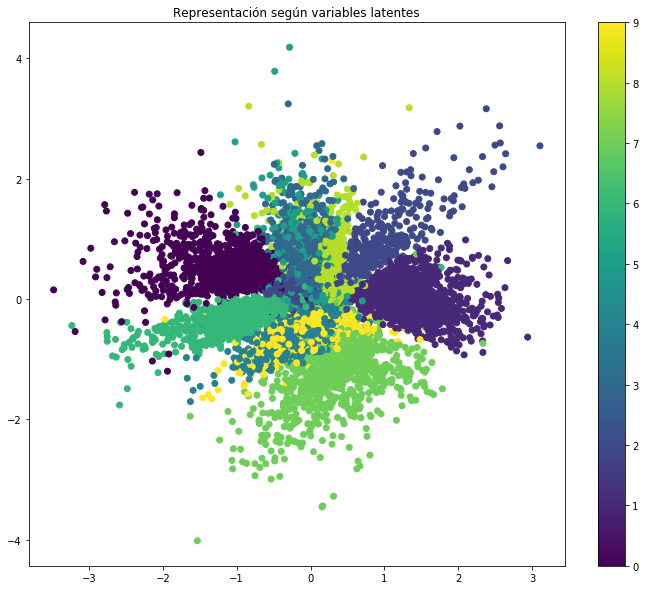

In [0]:
x_test_encoded = np.array(vae_encoder.predict(x_test, batch_size=batch_size))

plt.figure(figsize=(12, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.title("Representación según variables latentes")
plt.show()

**Histograma variables latentes**

La media está en las cercanias de cero para ambos componentes

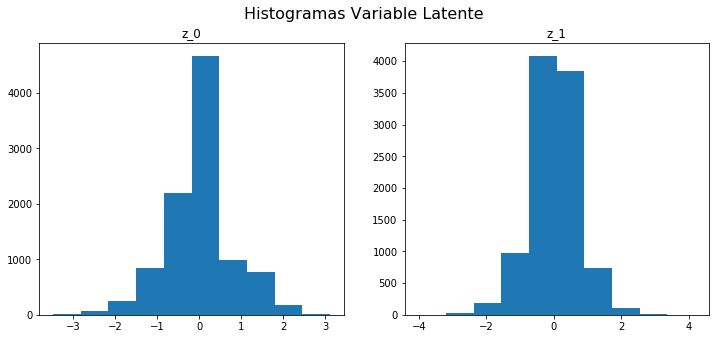

In [0]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Histogramas Variable Latente', fontsize=16)
axes[0].hist(x_test_encoded[:,0])
axes[1].hist(x_test_encoded[:,1])
axes[0].set_title("z_0")
axes[1].set_title("z_1")
plt.show()

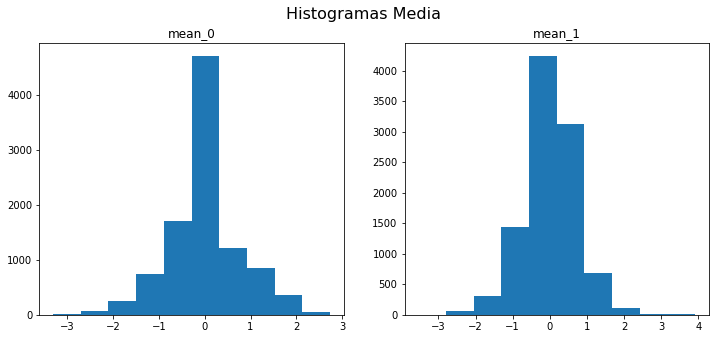

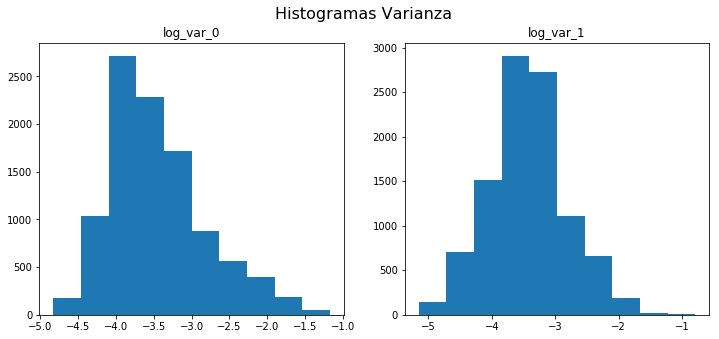

In [0]:
latents_test = encoder.predict(x_test, batch_size=batch_size)

# Histograma z_mean
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Histogramas Media', fontsize=16)
axes[0].hist(latents_test[0][:,0])
axes[1].hist(latents_test[0][:,1])
axes[0].set_title("mean_0")
axes[1].set_title("mean_1")
plt.show()

# Histograma z_log_var
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Histogramas Varianza', fontsize=16)
axes[0].hist(latents_test[1][:,0])
axes[1].hist(latents_test[1][:,1])
axes[0].set_title("log_var_0")
axes[1].set_title("log_var_1")
plt.show()

## g)

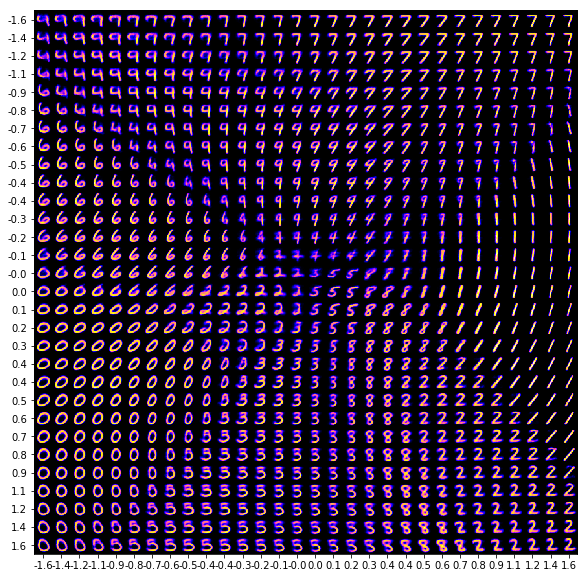

In [0]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

n = 30  # figure with 15x15 images 
image_size = img_cols # 28
figure = np.zeros((image_size * n, image_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) #metodo de la transformada inversa
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
# Plot
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()


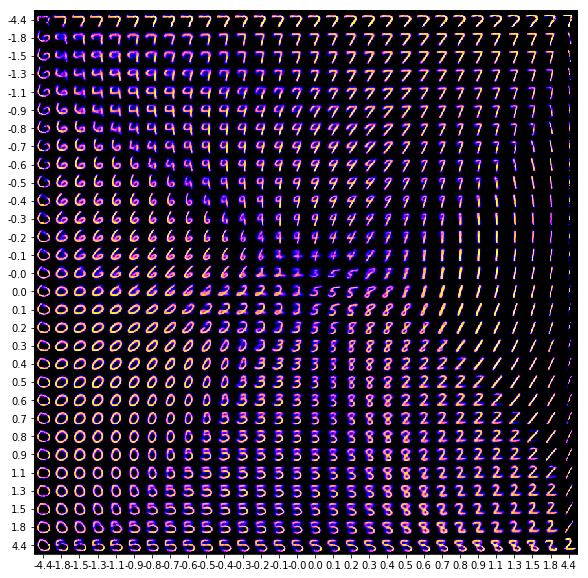

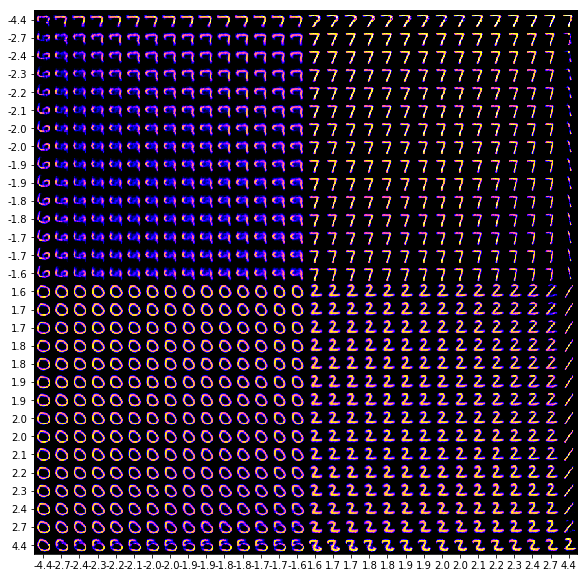

In [0]:
grid_x = norm.ppf(np.linspace(0.000005, 0.999995, n))
grid_y = norm.ppf(np.linspace(0.000005, 0.999995, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
# Plot
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()


#grid = norm.ppf(np.linspace(0.000005, 0.999995, n)) #en los extremos del intervalo de confianza
#grid_x = norm.ppf(np.linspace(0.000005, 0.999995, n))
#grid_y = norm.ppf(np.linspace(0.000005, 0.999995, n))
grid_x = np.concatenate((norm.ppf(np.linspace(0.000005, 0.05, int(n/2))), norm.ppf(np.linspace(0.95, 0.999995, int(n/2)))))
grid_y = np.concatenate((norm.ppf(np.linspace(0.000005, 0.05, int(n/2))), norm.ppf(np.linspace(0.95, 0.999995, int(n/2)))))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
# Plot
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()

## h)

In [0]:
filters = 32 # number of convolutional filters to use
num_conv = 3 # convolution kernel size
intermediate_dim = 128
latent_dim = 32

# Encoder
x = Input(shape=original_img_size, name="input_vae")
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu', name="conv_1")(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu', name="conv_2")(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2, name="conv_3")(conv_2)
flat = Flatten(name="flat_enco")(conv_3)
hidden = Dense(intermediate_dim, activation='relu', name="inter_enco")(flat)
z_mean = Dense(latent_dim,activation='linear', name="z_mean")(hidden)
z_log_var = Dense(latent_dim,activation='linear', name="z_log_var")(hidden)
# Decoder Layers
#decoder_hid = Dense(intermediate_dim, activation='relu', name="inter_deco")
#decoder_upsample = Dense(np.prod(K.int_shape(conv_3)[1:]), activation='relu', name="upsampling")
#decoder_reshape = Reshape(K.int_shape(conv_3)[1:], name="reshape_deco")
#decoder_deconv_1 = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=2, activation='relu', name="convT_1")
#decoder_deconv_2 = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', activation='relu', name="convT_2")
#decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv, padding='same', activation='sigmoid', name="convT_3")
# Decoder
z = Lambda(make_sampling(latent_dim), output_shape=(latent_dim,), name="sampling")([z_mean, z_log_var])
hid_decoded = Dense(intermediate_dim, activation='relu', name="inter_deco")(z)
up_decoded = Dense(np.prod(K.int_shape(conv_3)[1:]), activation='relu', name="upsampling")(hid_decoded)
reshape_decoded =  Reshape(K.int_shape(conv_3)[1:], name="reshape_deco")(up_decoded)
deconv_1_decoded = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=2, activation='relu', name="convT_1")(reshape_decoded)
x_decoded_relu = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', activation='relu', name="convT_2")(deconv_1_decoded)
x_decoded_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv, padding='same', activation='sigmoid', name="convT_3")(x_decoded_relu)


# Modelos
vae_norm = Model(x, x_decoded_mean_squash) # instantiate VAE model
vae_encoder = Model(x, z)

# Loss
reconstruction_loss = img_rows * img_cols * channel* mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #closed form
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_norm.add_loss(vae_loss)

# Summary
vae_norm.summary()
print()

# Train
batch_size = 128
epochs =  30
vae_norm.compile(optimizer='rmsprop')
vae_norm.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_vae (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 28, 28, 32)   320         input_vae[0][0]                  
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 28, 28, 32)   9248        conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 14, 14, 64)   18496       conv_2[0][0]                     
__________________________________________________________________________________________________
flat_enco 

In [0]:
re_encoded_test = np.empty((nplot, 64))
re_encoded_test[:,:32] = encoded_test[0]
re_encoded_test[:,32:] = encoded_test[1]
re_encoded_test[0]

array([-1.01709869e-02,  1.05198715e-02, -2.50021964e-01,  2.15870366e-02,
        1.43115679e-02,  8.58819485e-01,  3.41671705e-02,  8.65227759e-01,
        2.47216783e-03, -9.50473011e-01, -2.81218737e-01, -1.01887668e-02,
        1.09753674e-02,  2.56197248e-03, -6.65066112e-03, -2.94298589e-01,
       -1.20851574e-02, -5.54739125e-03, -1.07228887e+00,  1.81381721e-02,
       -1.22385155e-02,  1.93565726e-01, -6.57545868e-03, -9.55117121e-03,
        5.52094698e-01, -1.51427705e-02, -1.69195794e-02,  3.80271999e-03,
       -6.35447979e-01,  1.79710630e-02,  2.94314940e-02, -4.95150685e-01,
        1.73804536e-03, -2.45403871e-02, -1.33229744e+00,  2.60369852e-03,
       -1.61335617e-02, -1.91636562e+00, -2.45234108e+00, -1.35141313e+00,
       -1.73043814e-02, -2.32697415e+00, -1.90100372e+00, -1.56769417e-02,
        1.99375674e-03, -1.77565534e-02, -2.47196108e-03, -1.26696730e+00,
       -1.61459818e-02, -5.40238153e-03, -1.85332918e+00, -2.09538974e-02,
       -6.59616059e-03, -

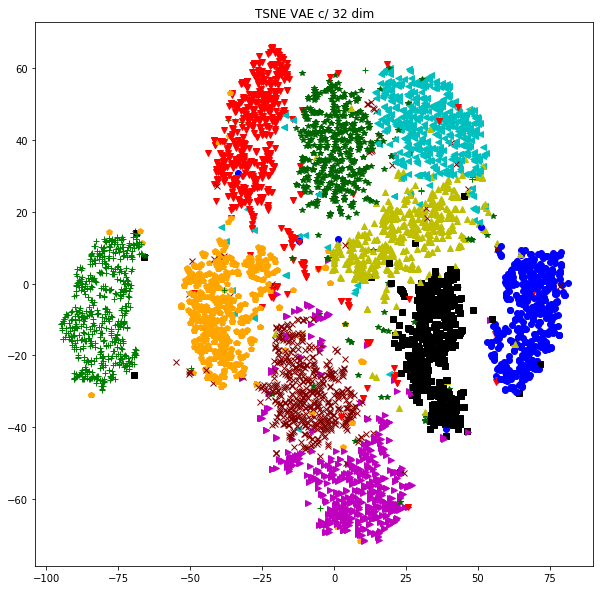

In [0]:
model = TSNE(n_components=2, random_state=0)
encoded_test = model.fit_transform(re_encoded_test)

plt.figure(figsize=(10, 10))
plt.title("TSNE VAE c/ {} dim".format(32))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
  label = y_test[idx]
  line = plt.plot(encoded_test[idx][0], encoded_test[idx][1],
                  color=colors[label], marker=markers[label], markersize=6)

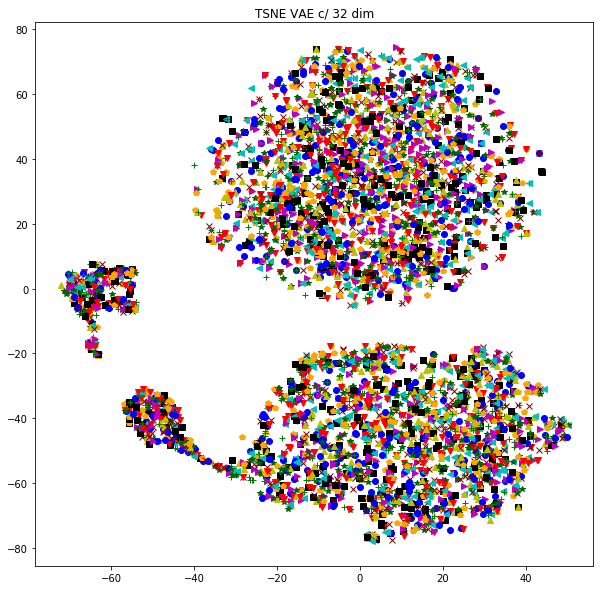

In [0]:
nplot=5000
vae_encoder2 = Model(x, [z_mean, z_log_var])
encoded_test = np.array(vae_encoder2.predict(x_test[:nplot], batch_size=batch_size)).reshape((nplot, 64))
model = TSNE(n_components=2, random_state=0)
encoded_test = model.fit_transform(encoded_test)

plt.figure(figsize=(10, 10))
plt.title("TSNE VAE c/ {} dim".format(32))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
  label = y_test[idx]
  line = plt.plot(encoded_test[idx][0], encoded_test[idx][1],
                  color=colors[label], marker=markers[label], markersize=6)

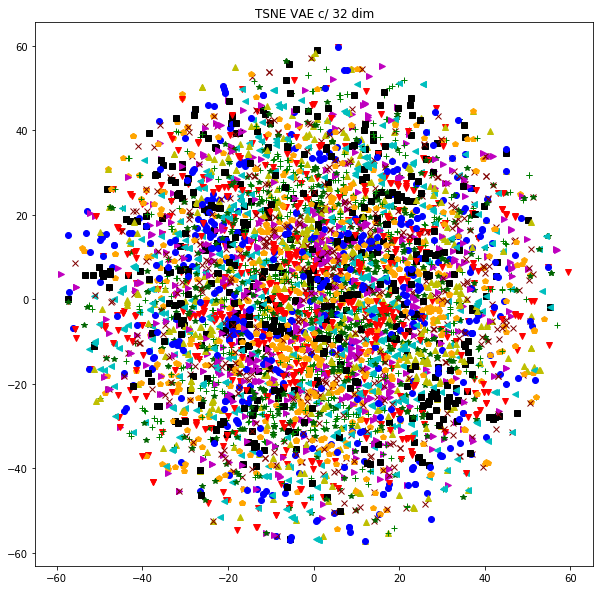

In [0]:
nplot=5000
encoded_test = np.array(vae_encoder.predict(x_test[:nplot], batch_size=batch_size))
model = TSNE(n_components=2, random_state=0)
encoded_test = model.fit_transform(encoded_test)

plt.figure(figsize=(10, 10))
plt.title("TSNE VAE c/ {} dim".format(32))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
  label = y_test[idx]
  line = plt.plot(encoded_test[idx][0], encoded_test[idx][1],
                  color=colors[label], marker=markers[label], markersize=6)

## 4.3 Variational Autoencoder categórico

### a)

**Sampling**

In [0]:
from keras.activations import softmax

In [0]:
def sample_gumbel(shape, eps=K.epsilon()):
  """Inverse Sample function from Gumbel(0, 1)"""
  U = K.random_uniform(shape, 0, 1)
  return - K.log( -K.log(U + eps) + eps)

def sampling(logits_z):
  """ Perform a Gumbel-Softmax sampling"""
  tau = K.variable(2/3, name="temperature")
  z = logits_z + sample_gumbel(K.shape(logits_z)) # logits + gumbel noise
  return softmax( z/tau )

In [10]:
filters = 32 # number of convolutional filters to use
num_conv = 3 # convolution kernel size
intermediate_dim = 128
latent_dim = 10

# Encoder
x = Input(shape=original_img_size, name="input_vae")
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu', name="conv_1")(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu', name="conv_2")(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2, name="conv_3")(conv_2)
flat = Flatten(name="flat_enco")(conv_3)
hidden = Dense(intermediate_dim, activation='relu', name="inter_enco")(flat)
logits_z = Dense(latent_dim, activation='linear', name="logits_z")(hidden) #log(p(z))
# Decoder Layers
decoder_hid = Dense(intermediate_dim, activation='relu', name="inter_deco")
decoder_upsample = Dense(np.prod(K.int_shape(conv_3)[1:]), activation='relu', name="upsampling")
decoder_reshape = Reshape(K.int_shape(conv_3)[1:])
decoder_deconv_1 = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=2, activation='relu', name="convT_1")
decoder_deconv_2 = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', activation='relu', name="convT_2")
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv, padding='same', activation='sigmoid', name="convT_3")
# Decoder
z = Lambda(sampling, output_shape=(latent_dim,), name="cat_sampling")(logits_z)
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

# Modelos
vae_norm = Model(x, x_decoded_mean_squash) # instantiate VAE model
vae_encoder = Model(x, logits_z)

# Loss
reconstruction_loss = img_rows * img_cols * channel * mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
dist =  softmax(logits_z) # =p(z)
dist_neg_entropy = K.sum(dist * K.log(dist + K.epsilon()), axis=1) # reconstruction_loss
kl_disc_loss =  np.log(latent_dim) + dist_neg_entropy #discrete KL-loss
vae_loss = K.mean(reconstruction_loss + kl_disc_loss)
vae_norm.add_loss(vae_loss)


# Summary
vae_norm.summary()

W0801 20:34:25.878373 139861156054912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1521: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_vae (InputLayer)       (None, 28, 28, 1)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 32)        9248      
_________________________________________________________________
conv_3 (Conv2D)              (None, 14, 14, 64)        18496     
_________________________________________________________________
flat_enco (Flatten)          (None, 12544)             0         
_________________________________________________________________
inter_enco (Dense)           (None, 128)               1605760   
_________________________________________________________________
logits_z (Dense)             (None, 10)                1290      
__________

In [0]:
choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss

In [0]:
dist =  softmax(logits_z) # =p(z)
dist_neg_entropy = K.sum(dist * K.log(dist + K.epsilon()), axis=1) # reconstruction_loss

kl_disc_loss =  np.log(latent_dim) + dist_neg_entropy #discrete KL-loss

vae_loss = K.mean(dist_neg_entropy + kl_disc_loss)

vae_norm.add_loss(vae_loss)

In [0]:

x_prob = softmax(x_hat)
recons_loss = torch.sum(x * torch.log(x_prob + eps), dim=1)

# KL Divergence = entropy (self.latent) - cross_entropy(self.latent, uniform log-odds)
q_y = softmax(self.hidden) # convert hidden layer values to probabilities
kl1 = q_y * torch.log(q_y + eps) # entropy (self.latent)
kl2 = q_y * np.log((1.0/self.K) + eps)

KL_divergence = torch.sum(torch.sum(kl1 - kl2, 2),1)

# total loss = reconstruction loss + KL Divergence
loss = -torch.mean(recons_loss - KL_divergence)
self.recons_loss = -torch.mean(recons_loss).data[0] # for visualization purposes
self.kl_loss = -torch.mean(-KL_divergence).data[0]  # for visualization purposes
return loss 

### b)

In [12]:
batch_size = 128
epochs = 30

vae_norm.compile(optimizer='rmsprop')
vae_norm.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 20s 335us/step - loss: 41.5968 - val_loss: 39.8939
Epoch 2/30
60000/60000 [==============================] - 19s 323us/step - loss: 38.9861 - val_loss: 37.6689
Epoch 3/30
60000/60000 [==============================] - 19s 323us/step - loss: 37.0486 - val_loss: 36.1916
Epoch 4/30
60000/60000 [==============================] - 19s 324us/step - loss: 35.5807 - val_loss: 35.3231
Epoch 5/30
60000/60000 [==============================] - 19s 323us/step - loss: 34.3931 - val_loss: 34.1395
Epoch 6/30
60000/60000 [==============================] - 19s 324us/step - loss: 33.5218 - val_loss: 33.2155
Epoch 7/30
60000/60000 [==============================] - 19s 323us/step - loss: 32.7840 - val_loss: 33.2230
Epoch 8/30
60000/60000 [==============================] - 19s 323us/step - loss: 32.1523 - val_loss: 32.2138
Epoch 9/30
60000/60000 [==============================] - 19s 324us/step - los

### c) Evaluación

Ya que los valores de las etiquetas de cada clase no se corresponden entre las etiquetas usadas por el VAE y las etiquetas reales. 

Es necesario que la evaluación que también el vae es capaz de separar los datos en _clusters_ con respecto a un _ground true_ dado. Es decir, que la separación hecha por el vae sea similar a la dada como verdadera, independiente del valor de la etiqueta usado para cada clase o cluster.

Ajuste contra azar: número de clases << número de ejemplos x clase

In [0]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score

In [16]:
def mysoftmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - x.max(axis=-1, keepdims=True) )
    return e_x / e_x.sum(axis=-1, keepdims=True)
p_z_train = mysoftmax(vae_encoder.predict(x_train))
p_z_test = mysoftmax(vae_encoder.predict(x_test))
y_train_pred = p_z_train.argmax(axis=-1)
y_test_pred = p_z_test.argmax(axis=-1)

0.2871039220462142
0.3108675408518277


In [33]:
# Adjusted Rand index
print(adjusted_rand_score(y_train, y_train_pred))
print(adjusted_rand_score(y_test, y_test_pred))

0.1691516710694056
0.18757363109535496


In [30]:
# Normalized Mutual Info
print(normalized_mutual_info_score(y_train, y_train_pred))
print(normalized_mutual_info_score(y_test, y_test_pred))

0.2871039220462142
0.3108675408518277


In [35]:
# Fowlkes-Mallows index
print(fowlkes_mallows_score(y_train, y_train_pred))
print(fowlkes_mallows_score(y_test, y_test_pred))

0.2544533105717296
0.2711692682031001


In [25]:
# TODO no se si dejar esto.
metrics.cluster.contingency_matrix(y_train, y_train_pred)

array([[ 212, 2487,  424,  882,  121,  253,  199,   52,   68, 1225],
       [   6,    0, 1214,    2,    1,  107,  441, 3319, 1652,    0],
       [ 980,  206,   26,  427,  100,  719,  559,  429, 2470,   42],
       [  53,  118,    4,  208,  328,   82,  508, 1104,  966, 2760],
       [1947,    2, 1822,  425,  443,  160,  593,  422,   28,    0],
       [ 191,   73,  463, 1489,   40,   88,  383,  525,   23, 2146],
       [ 361,  464,   82, 1538,    0, 2585,  545,  315,    2,   26],
       [  39,  615,  165,    8, 2600,    9, 1239,  981,  608,    1],
       [ 355,    6, 1521,  154,  294,  295,  557,  145,  531, 1993],
       [ 529,   21,  464,  350, 2005,   17, 1969,  398,  137,   59]])

In [26]:
metrics.confusion_matrix(y_train, y_train_pred)

array([[ 212, 2487,  424,  882,  121,  253,  199,   52,   68, 1225],
       [   6,    0, 1214,    2,    1,  107,  441, 3319, 1652,    0],
       [ 980,  206,   26,  427,  100,  719,  559,  429, 2470,   42],
       [  53,  118,    4,  208,  328,   82,  508, 1104,  966, 2760],
       [1947,    2, 1822,  425,  443,  160,  593,  422,   28,    0],
       [ 191,   73,  463, 1489,   40,   88,  383,  525,   23, 2146],
       [ 361,  464,   82, 1538,    0, 2585,  545,  315,    2,   26],
       [  39,  615,  165,    8, 2600,    9, 1239,  981,  608,    1],
       [ 355,    6, 1521,  154,  294,  295,  557,  145,  531, 1993],
       [ 529,   21,  464,  350, 2005,   17, 1969,  398,  137,   59]])

### d)

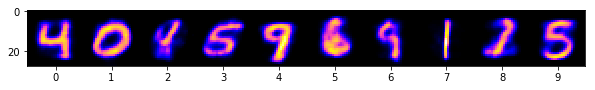

In [36]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)

generator = Model(decoder_input, _x_decoded_mean_squash) 
predictions =np.zeros((img_cols * 1 ,img_cols* latent_dim))

for i in range(latent_dim):
    activate_aux = np.zeros((1,10))
    activate_aux[:,i] = 1 #activate a class
    predictions[:,i * img_cols:(i + 1) * img_cols] = np.squeeze(generator.predict(activate_aux))

plt.figure(figsize=(10, 10))
plt.imshow(predictions, cmap='gnuplot2')
pos = np.arange(img_cols/2, img_cols*latent_dim, img_cols)
plt.xticks(pos,range(latent_dim))
plt.show()

### e)